Author: Sanjeev Dahal <br>
Script for creating limedFBA model of iSD1507, and simulating on different oxygen availability and pyocyanin production rates

### import all packages

In [1]:
#cobra package
import cobra
from cobra import Model, Reaction, Metabolite


#other packages
import os
from os.path import join
import pandas as pd
import numpy as np
import re

#for plotting
from matplotlib import cm
import matplotlib.pyplot as plt

In [2]:
mydir = os.getcwd() #set the directory to the current one

In [3]:
#loading the model
model_iSD = cobra.io.read_sbml_model(join(mydir, 'iSD1507M.xml'))

Using license file /Users/sanjeevdahal/gurobi.lic
Academic license - for non-commercial use only


### creating limedFBA model

In [4]:
# convert all to irreversible
for reactions in model_iSD.reactions:
    newcoeff = {}
    if reactions.lower_bound < 0. and reactions.upper_bound > 0.:
        if reactions.id.startswith('EX_'):
            pass
        else:
            reactions.bounds = 0., 1000.

            rxnid = reactions.id + "_irrev2"
            newRxn = Reaction(id = rxnid)
            model_iSD.add_reactions([newRxn])

            for mets in reactions.metabolites:
                newcoeff[mets.id] = -1.*reactions.get_coefficient(mets.id)

            newRxn.add_metabolites(newcoeff)
            
            


#get the metabolites that are constituents of biomass
biomassmets = [k.id for k in model_iSD.reactions.BIOMASS_PA14_v27M.metabolites]


epsii_met_dict = {} #get the epsilon(e) value for each metabolite


for reactions in model_iSD.reactions:    
    for mets in reactions.metabolites:
        sum_binsto = 0. #sum of the binary stoichiometry of the metabolite
        rxn = [] #reactions for the specific metabolite
        for met_rs in model_iSD.metabolites.get_by_id(mets.id).reactions:
            reactant = [r.id for r in met_rs.reactants]
            product = [r.id for r in met_rs.products]
            
            if len(reactant) == 1 and len(product) == 1 and reactant[0][:-2] == product[0][:-2]:
                sum_binsto += 0 #if simple transport, then Sbinary = 0 for that specific metabolite for that reaction.
            else:
                sum_binsto += 1
                rxn.append(met_rs.id)

        
        if sum_binsto == 0:
            epsii_met = 0.1
        else:
            epsii_met = 0.1/(1000.*sum_binsto)
            
        if mets.id in epsii_met_dict.keys():
            pass
        else:
            epsii_met_dict[mets.id] = epsii_met

In [5]:
#(S-e*Sbinary)
for reactions in model_iSD.reactions:
    met2newcoeff = {}
    if 'pyo_c' in [x.id for x in reactions.metabolites]:
        if 'pyo_e' in [x.id for x in reactions.metabolites]: #for transport, binary coeff is 0
            binarycoeff = 0.
            newcoeff = coeff - epsii_met_dict[mets.id] * binarycoeff
        else:
            newreaction = reactions.copy()

            reactions.reaction = '-->'
            for mets in newreaction.metabolites:
                coeff = newreaction.get_coefficient(mets)
                binarycoeff = 1.
                if mets.id in biomassmets: #if in biomass, then e = 0
                    newcoeff = coeff - 0. * binarycoeff
                else:
                    newcoeff = coeff - epsii_met_dict[mets.id] * binarycoeff 

                met2newcoeff[mets] = newcoeff

            reactions.add_metabolites(met2newcoeff)
        
        print(reactions)

rxn11546: gly_c + 2.0000125 pyo_c --> 0.99999918699187 co2_c + 0.9999666666666667 cyan_c + 1.9999833333333332 pyoh2_c
rxn13896: 1.0000166666666668 5mpca_c + 1.0000006451612904 nadh_c + 1.0000013157894736 o2_c --> 0.99999918699187 co2_c + h2o_c + 0.9999993788819875 nad_c + 0.9999875 pyo_c
AKGDHPYO: 1.0000021276595745 akg_c + coa_c + h_c + 1.0000125 pyo_c --> 0.99999918699187 co2_c + 0.9999833333333333 pyoh2_c + 0.9999928571428571 succoa_c
PDHPYO: coa_c + h_c + 1.0000125 pyo_c + 1.0000021276595745 pyr_c --> 0.9999978723404256 accoa_c + 0.99999918699187 co2_c + 0.9999833333333333 pyoh2_c
PYOtex: pyo_e --> pyo_c
NADHPYO: h_c + 1.0000006451612904 nadh_c + 1.0000125 pyo_c --> 0.9999993788819875 nad_c + 0.9999833333333333 pyoh2_c
NADPHPYO: h_c + 1.0000006944444444 nadph_c + 1.0000125 pyo_c --> 0.9999993103448276 nadp_c + 0.9999833333333333 pyoh2_c
rxn11546_irrev2: 1.0000008130081302 co2_c + 1.0000333333333333 cyan_c + 2.0000166666666668 pyoh2_c --> gly_c + 1.9999875 pyo_c
rxn13896_irrev2: 1.0

### previous steps convert iSD1507 to iSD1507_limed for pyocyanin-based reactions

In [6]:
# storing default boundaries for the model
original_bounds_dict = {}
for r in model_iSD.reactions:
    lb, ub = model_iSD.reactions.get_by_id(r.id).lower_bound, model_iSD.reactions.get_by_id(r.id).upper_bound
    original_bounds_dict[r.id] = [lb, ub]

In [7]:
lb_media = pd.read_excel(join(mydir, 'media_LB_SCFM_MM.xlsx'), sheet_name= 'LB', header=0)

medium = {}
for met in lb_media.metabolites:
    metrxn = "EX_" + met + "_e"
    medium[metrxn] = abs(np.float(lb_media[lb_media.loc[:,'metabolites'] == met].lb.values[0]))

    
#check whether growth of iSD1507_limed in LB media is same as iSD1507
with model_iSD:
    for k in model_iSD.reactions:
        k.bounds = original_bounds_dict[k.id][0], original_bounds_dict[k.id][1]
    #check whether growth in LB media is same as iSD1507
    model_iSD.medium = medium

    objective = 'BIOMASS_PA14_v27M'
    model_iSD.reactions.get_by_id(objective).bounds = 0., 1000.
    model_iSD.objective = objective

    print(model_iSD.slim_optimize())

1.5323746804956209


### find the highest pyocyanin production rate first for iSD1507_limed

In [8]:
with model_iSD:
    #reset the flux bounds
    for k in model_iSD.reactions:
        k.bounds = original_bounds_dict[k.id][0], original_bounds_dict[k.id][1]
    #set the medium
    model_iSD.medium = medium
    
    #set the objective
    objective = 'BIOMASS_PA14_v27M'
    model_iSD.reactions.get_by_id(objective).bounds = 0., 1000.
    model_iSD.objective = objective
    
    #set the oxygen flux to 0.5
    model_iSD.reactions.O2tex.bounds = 0., 0.5
    
    #simulate
    solution_phz_growth = model_iSD.optimize()
    
    #store the pyocyanin production flux to a variable
    max_pyo_syn_flux_limed = solution_phz_growth['rxn13896']
    
print(max_pyo_syn_flux_limed)

0.0008818086649726025


In [9]:
o2_pyo_gr = {} #dictionary to store the data for oxygen availability, pyocyanin production and growth rates

with model_iSD:
    #O2tex flux ranges
    for o2flux in np.arange(0.5, 10.5, 0.5):
        pyo_gr = {} #dictionary to store the data for pyocyanin production and growth rates
        
        #pyocyanin production flux ranges
        for pyo_flux in np.arange(max_pyo_syn_flux_limed/10., (max_pyo_syn_flux_limed + max_pyo_syn_flux_limed/10.), max_pyo_syn_flux_limed/10.):
            #reset the flux bounds
            for k in model_iSD.reactions:
                k.bounds = original_bounds_dict[k.id][0], original_bounds_dict[k.id][1]

            #set the medium
            model_iSD.medium = medium

            #set the objective
            objective = 'BIOMASS_PA14_v27M'
            model_iSD.reactions.get_by_id(objective).bounds = 0., 1000.
            model_iSD.objective = objective
    
            #set the oxygen uptake rate and pyocyanin production rate
            model_iSD.reactions.O2tex.bounds = o2flux, o2flux
            model_iSD.reactions.rxn13896.bounds = pyo_flux, pyo_flux
            
            #simulate
            solution = model_iSD.optimize()
            
            #storing in the dictionary pyo_gr
            if solution.status == 'optimal':
                pyo_gr[solution['rxn13896']] = solution.objective_value
            else:
                pyo_gr[solution['rxn13896']] = 0.
        
        #store the oxygen-pyocyanin-growth in o2_pyo_gr dictionary
        o2_pyo_gr[solution['O2tex']] = pyo_gr
        
#convert o2_pyo_gr dictionary to a dataframe for easier plotting
df_solution_o2_gr_pyo = pd.DataFrame.from_records(o2_pyo_gr)

<IPython.core.display.Javascript object>


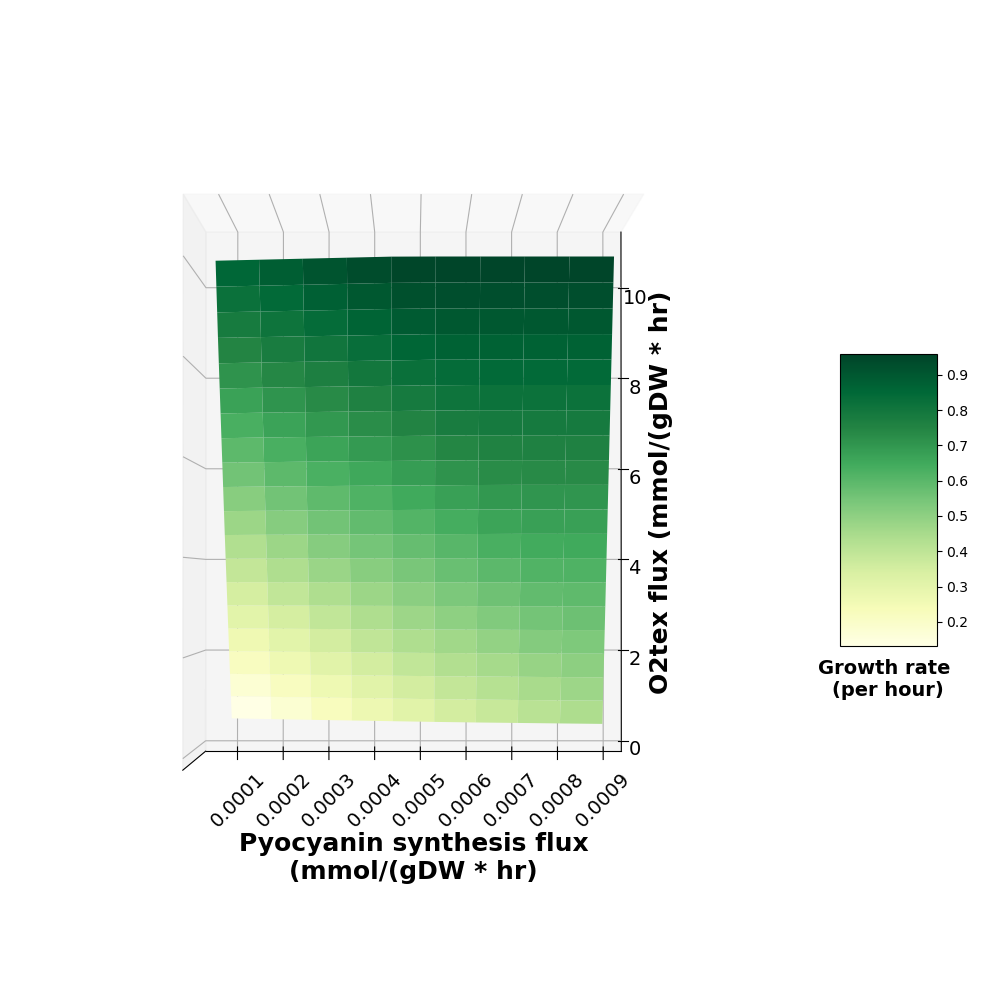

In [10]:
# plotting
%matplotlib notebook

x = df_solution_o2_gr_pyo.columns #x values (oxygen uptake rates)
y = df_solution_o2_gr_pyo.index #y values (pyocyanin production rates)
X,Y = np.meshgrid(x,y)
Z = df_solution_o2_gr_pyo.to_numpy() #for Z axis


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
myplot = ax.plot_surface(X, Y, Z, cmap=cm.YlGn , alpha=1.0)

#disable rotation of labels
ax.xaxis.set_rotate_label(False)

#setting labels
ax.set_xlabel("O2tex flux (mmol/(gDW * hr)", fontdict={'weight':'bold', 'size':18}, labelpad=12, rotation=90)
ax.set_ylabel("Pyocyanin synthesis flux\n(mmol/(gDW * hr)", fontdict={'weight':'bold', 'size':18}, labelpad=50)

#setting the limits
ax.set_xlim(11, 0)

##setting the z-ticks
ax.set_zticks([])

## rotate the y-ticks
plt.yticks(rotation=45)

#set the parameters for x and y axis
plt.tick_params(axis='both', labelsize=14)

ax.view_init(azim=0, elev=89) #setting the elevation
colorbar = fig.colorbar(myplot, aspect=3, shrink=0.3) #colorbar parameters
colorbar.ax.set_xlabel('Growth rate \n(per hour)', fontdict={'weight':'bold', 'size':14}, labelpad=10)

plt.tight_layout()
plt.show()